# Impronta ambientale vs sviluppo umano (1990-2023): chi paga il prezzo più alto?

**Autore:** Francesco Petriaggi  
**Versione:** 1.0 – maggio 2025  
**Licenza notebook & codice:** MIT  
**Fonte dati:** World Bank – World Development Indicators (CC BY 4.0)


## Sommario

1. [Introduzione](#Introduzione)  
   1.1 [Obiettivi](#Obiettivi)  
   1.2 [Descrizione-del-dataset](#Descrizione-del-dataset)  
   1.3 [Variabili-chiave](#Variabili-chiave)

2. [Setup-ambiente](#Setup-ambiente)

3. [Caricamento-dati](#Caricamento-dati)

4. [Pre-processing](#Pre-processing)  
   4.1 [Snapshot-2023](#Snapshot-2023)  
   4.2 [Variabili-derivate](#Variabili-derivate)

5. [Analisi-descrittiva](#Analisi-descrittiva)  
   5.1 [Statistiche-e-istogramma](#Statistiche-e-istogramma)  
   5.2 [Top--Bottom-10](#Top--Bottom-10)  
   5.3 [Correlazioni](#Correlazioni)  
   5.4 [Driver-nei-Top-10](#Driver-nei-Top-10)  
   5.5 [Outlier-IQR](#Outlier-IQR)

6. [Analisi-per-gruppi](#Analisi-per-gruppi)  
   6.1 [Per-regione](#Per-regione)  
   6.2 [Per-categoria-HDI](#Per-categoria-HDI)

7. [Mappe-geografiche](#Mappe-geografiche)  
   7.1 [Mappa-gap_pct](#Mappa-gap_pct)  
   7.2 [Mappa-CO2-pro-capite](#Mappa-CO2-pro-capite)  
   7.3 [Mappa-Material-Footprint](#Mappa-Material-Footprint)

8. [Analisi-temporale](#Analisi-temporale)  
   8.1 [Delta-gap_pct-1990-2023](#Delta-gap_pct-1990-2023)  
   8.2 [Trend-regionale-1990-2023](#Trend-regionale-1990-2023)

9. [Segmentazione-a-quadranti-2023](#Segmentazione-a-quadranti-2023)

10. [Conclusioni-e-Raccomandazioni](#Conclusioni-e-Raccomandazioni)  
    10.1 [Punti-chiave](#Punti-chiave)  
    10.2 [Azioni-di-policy](#Azioni-di-policy)


## 1. Introduzione

### 1.1 Obiettivi  

> **Domanda guida**  
> *In che misura le pressioni ambientali — emissioni di CO₂ pro-capite e Material Footprint pro-capite — ridimensionano lo sviluppo umano (HDI) nei diversi Paesi?*

Per rispondere:

- **Calcoliamo la perdita di HDI** dovuta alle pressioni planetarie, in valore assoluto (`gap`) e in percentuale (`gap_pct`).  
- **Valutiamo l’importanza relativa** di CO₂ e Material Footprint tramite analisi di correlazione e z-score.  
- **Segmentiamo i Paesi** in quattro categorie (quadranti) usando soglie su `gap_pct` e `mf_pc`, per evidenziare chi combina alta pressione ambientale e alta perdita di HDI.  
- **Confrontiamo i risultati** per *regione* e per *fascia di sviluppo umano* (classi UNDP).  
- **Analizziamo la dinamica storica** 1990 – 2023 per vedere chi migliora o peggiora la propria “efficienza ambientale”.

### 1.2 Descrizione del dataset  

| Caratteristica | Dettaglio |
|---------------|-----------|
| **Fonte** | World Bank – *[World Development Indicators](https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators)* |
| **Formato** | CSV |
| **Dimensioni** | 206 righe × 1 112 colonne (193 Paesi + 13 aggregati regionali, serie 1990-2023) |
| **Copertura temporale** | 1990 – 2023 (34 anni) |
| **Unità di analisi** | Paese/aggregato × anno |
| **Licenza** | Creative Commons Attribution 4.0 (CC BY 4.0) |

### 1.3 Variabili chiave (snapshot 2023)

| Colonna | Descrizione | Scala |
|---------|-------------|-------|
| `hdi` | Human Development Index | 0 – 1 |
| `phdi` | HDI corretto per le pressioni planetarie | 0 – 1 |
| `co2_pc` | Emissioni di CO₂ pro-capite | t/anno |
| `mf_pc`  | Material Footprint pro-capite | t/anno |

> **Nota tecnica** – Dal file storico estraiamo le colonne 2023 e calcoliamo:  
> `gap  = hdi − phdi` (perdita assoluta)  
> `gap_pct = 100 × gap / hdi` (perdita percentuale)


## 2. Setup ambiente

In questa sezione inizializziamo tutto ciò che serve per eseguire il notebook in modo
riproducibile e ordinato.

* **Import unificato**  
  - Manipolazione dati: `pandas`, `numpy`  
  - Visualizzazione statica: `matplotlib.pyplot`, `seaborn`  
  - Visualizzazione interattiva: `plotly.express`, `plotly.graph_objects`  
  - Pre-processing: `sklearn.preprocessing.StandardScaler`    
  - Utility di sistema: `os`, `random`, `warnings`

* **Seed globale**  
  `np.random.seed(42)` e `random.seed(42)` per risultati replicabili.

* **Pulizia output**  
  `warnings.filterwarnings('ignore')` per sopprimere avvisi non critici.


In [ ]:
import os
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler

# Imposta seed per risultati riproducibili
np.random.seed(42)
random.seed(42)


## 3. Caricamento dati

In questa sezione importiamo il file CSV nel *DataFrame* `df` e facciamo i controlli
essenziali per assicurarci che tutto sia in ordine.

**Passaggi**

1. **Lettura del file**  
   Il percorso è letto dalla variabile d’ambiente `DATA_PATH`; se non è definita
   usiamo il file locale `HDR25_Composite_indices_complete_time_series.csv`.
2. **Verifica rapida**  
   * `df.shape` → conferma che abbiamo 206 righe × 1 112 colonne.  
   * `df.head()` → ispeziona le prime righe per controllare intestazioni e formato.  
   * `df.info()` → riepiloga i tipi di dato e segnala eventuali valori nulli.  



In [ ]:
# 3. Caricamento dati
DATA_PATH = os.getenv('DATA_PATH', 'HDR25_Composite_indices_complete_time_series.csv')

df = pd.read_csv(DATA_PATH, encoding='latin1', low_memory=False)

# Controlli essenziali
print(f"Dataset caricato: {df.shape[0]} righe × {df.shape[1]} colonne")  # atteso: 206 × 1112
pd.set_option('display.max_columns', 25)  # mostra più colonne in head()
display(df.head())
df.info()
print("Valori nulli totali:", df.isna().sum().sum())

Dataset caricato: 206 righe × 1112 colonne


,iso3,country,hdicode,region,hdi_rank_2023,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,...,pop_total_2012,pop_total_2013,pop_total_2014,pop_total_2015,pop_total_2016,pop_total_2017,pop_total_2018,pop_total_2019,pop_total_2020,pop_total_2021,pop_total_2022,pop_total_2023
0,AFG,Afghanistan,Low,SA,181.0,0.285,0.291,0.301,0.311,0.305,0.329,0.334,...,30.560034,31.622704,32.792523,33.831764,34.700612,35.688935,36.743039,37.856121,39.068979,40.000412,40.578842,41.454761
1,ALB,Albania,Very High,ECA,71.0,0.654,0.638,0.622,0.624,0.629,0.638,0.647,...,2.910004,2.907573,2.903749,2.898632,2.897867,2.898242,2.894231,2.885009,2.871954,2.849636,2.827608,2.811655
2,DZA,Algeria,High,AS,96.0,0.595,0.596,0.601,0.603,0.603,0.608,0.615,...,37.646166,38.414172,39.205030,40.019529,40.850721,41.689299,42.505035,43.294546,44.042091,44.761099,45.477390,46.164219
3,AND,Andorra,Very High,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.076834,0.075193,0.073737,0.072174,0.072181,0.073762,0.075162,0.076473,0.077380,0.078364,0.079705,0.080856
4,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.177394,26.165620,27.160770,28.157798,29.183070,30.234839,31.297155,32.375633,33.451132,34.532429,35.635029,36.749906


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Columns: 1112 entries, iso3 to pop_total_2023
dtypes: float64(1108), object(4)
memory usage: 1.7+ MB
Valori nulli totali: 28310


## 4. Pre-processing

### 4.1 Estrazione dello snapshot 2023  

Scopo: isolare in un *DataFrame* leggero (⟨Paesi×6 colonne⟩) tutte le variabili 2023
di interesse, pronte per l’analisi descrittiva.

**Passaggi**

1. **Selezione colonne 2023**  
   - Manteniamo i descrittori `country`, `iso3`.  
   - Tra le colonne che terminano in `_2023` teniamo:  
     `hdi_2023`, `phdi_2023`, `co2_prod_2023`, `mf_2023`.  
     > *Se il tuo CSV usa un nome diverso (es. `co2_pc_2023`) cambialo nella lista*.
2. **Pulizia**  
   - `dropna()` rimuove le righe con dati mancanti su uno qualunque dei campi 2023.  
   - Restano ~170 Paesi/aggregati con record completi.
3. **Rinomina colonne** per leggibilità:  
   `hdi`, `phdi`, `co2_pc`, `mf_pc`.
4. **Verifica finale**  
   - `snap23.shape` → dovremmo avere ~170 righe × 6 colonne.  
   - `snap23.head()` per un controllo a vista.

*(Le colonne storiche 1990-2022 restano nel DataFrame principale `df` per le
analisi temporali più avanti.)*


In [ ]:
# 4.1 Snapshot 2023
# 1) Colonne da tenere (modifica se il nome nel CSV è diverso)
keep_cols = [
    'country', 'iso3',
    'hdi_2023', 'phdi_2023',
    'co2_prod_2023',   # ← cambia qui se necessario (es. 'co2_pc_2023')
    'mf_2023'
]

# 2) Estrai e rimuovi righe con NA
snap23 = df[keep_cols].copy().dropna()

# 3) Rinomina colonne
snap23 = snap23.rename(columns={
    'hdi_2023':      'hdi',
    'phdi_2023':     'phdi',
    'co2_prod_2023': 'co2_pc',
    'mf_2023':       'mf_pc'
})

# 4) Verifica output
print("Shape snapshot 2023:", snap23.shape)   # atteso ~170 × 6
display(snap23.head())


Shape snapshot 2023: (167, 6)


,country,iso3,hdi,phdi,co2_pc,mf_pc
0,Afghanistan,AFG,0.496,0.492,0.260896,1.2455
1,Albania,ALB,0.810,0.755,1.816209,10.0369
2,Algeria,DZA,0.763,0.706,3.905866,8.8042
4,Angola,AGO,0.616,0.604,0.566470,2.9376
6,Argentina,ARG,0.865,0.763,4.277679,16.3294


### 4.2 Calcolo delle variabili derivate  

Per confrontare sviluppo umano e pressioni ambientali costruiamo due nuove metriche:

| Variabile | Formula | Significato |
|-----------|---------|-------------|
| `gap` | `hdi − phdi` | perdita assoluta di HDI dovuta alle pressioni planetarie |
| `gap_pct` | `100 × gap / hdi` | perdita espressa in **percentuale** sull’HDI originale |

**Step operativi**

1. Calcoliamo `gap` e `gap_pct` direttamente su `snap23`.  
2. Mostriamo le prime 5 righe per un controllo a vista.  
3. Ricaviamo **minimo, massimo e media** di `gap_pct` per avere un quadro della
   dispersione tra i Paesi.

*(Nota: un valore di `gap_pct = 15` significa che, tenuto conto delle pressioni
planetarie, l’HDI effettivo è inferiore del 15 % rispetto al valore “teorico”.)*


In [ ]:
# ── 4.2 Variabili derivate ────────────────────────────────────────────
# 1) Perdita assoluta e percentuale
snap23['gap']     = snap23['hdi'] - snap23['phdi']
snap23['gap_pct'] = snap23['gap'] / snap23['hdi'] * 100

# 2) Anteprima
display(snap23[['country', 'hdi', 'phdi', 'gap', 'gap_pct']].head())

# 3) Statistiche sintetiche
min_gap  = snap23['gap_pct'].min()
max_gap  = snap23['gap_pct'].max()
mean_gap = snap23['gap_pct'].mean()

print(f"Gap % – min: {min_gap:.2f}, max: {max_gap:.2f}, media: {mean_gap:.2f}")


,country,hdi,phdi,gap,gap_pct
0,Afghanistan,0.496,0.492,0.004,0.806452
1,Albania,0.810,0.755,0.055,6.790123
2,Algeria,0.763,0.706,0.057,7.470511
4,Angola,0.616,0.604,0.012,1.948052
6,Argentina,0.865,0.763,0.102,11.791908


Gap % – min: 0.81, max: 68.85, media: 10.48


## 5. Esplorazione dei dati (EDA)

### 5.1 Statistiche descrittive e istogramma di `gap_pct`

**Obiettivo**  
Quantificare e visualizzare la distribuzione della perdita percentuale di HDI (`gap_pct`) tra i Paesi nello snapshot 2023.

| Passo | Azione | Insight atteso |
|-------|--------|----------------|
| 1 | `snap23['gap_pct'].describe()` | Media, deviazione, quartili: ci dicono se la maggioranza dei Paesi perde poco o molto HDI. |
| 2 | Istogramma + curva KDE | La forma della distribuzione rivela eventuali asimmetrie (coda lunga) o gruppi distinti di Paesi. |
| 3 | Linea verticale su media & mediana | Evidenzia se la distribuzione è sbilanciata (media ≠ mediana). |

> Un valore di `gap_pct` pari a 12 % significa che, tenuto conto delle pressioni
> planetarie, l’HDI effettivo è inferiore del 12 % rispetto al valore “teorico”.


count    167.00
mean      10.48
std       10.01
min        0.81
25%        2.89
50%        7.48
75%       14.60
max       68.85
Name: gap_pct, dtype: float64


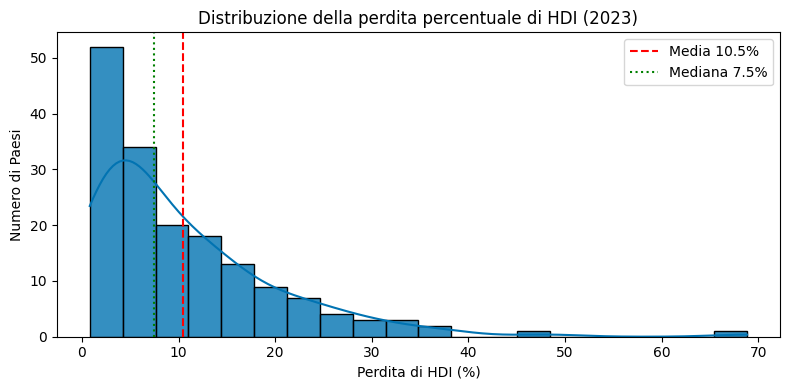

In [ ]:
# 5.1 Statistiche descrittive + istogramma
# 1) Statistiche descrittive
desc = snap23['gap_pct'].describe().round(2)
print(desc)

# 2) Istogramma con KDE
plt.figure(figsize=(8,4))
sns.histplot(snap23['gap_pct'],
             bins=20, kde=True,
             color=sns.color_palette("colorblind")[0], alpha=0.8)
plt.xlabel('Perdita di HDI (%)')
plt.ylabel('Numero di Paesi')
plt.title('Distribuzione della perdita percentuale di HDI (2023)')

# 3) Linee su media e mediana
mean_val = snap23['gap_pct'].mean()
median_val = snap23['gap_pct'].median()
plt.axvline(mean_val,   color='red',   linestyle='--', label=f'Media {mean_val:.1f}%')
plt.axvline(median_val, color='green', linestyle=':',  label=f'Mediana {median_val:.1f}%')
plt.legend()
plt.tight_layout()
plt.show()



### 5.2 Top-10 e Bottom-10 Paesi per `gap_pct`

**Obiettivo**  
Mettere in evidenza gli estremi della distribuzione: chi subisce la perdita
percentuale di HDI più alta (Top-10) e chi la più bassa (Bottom-10).

| Passo | Azione |
|-------|--------|
| 1 | `nlargest(10, 'gap_pct')` → Paesi più penalizzati. |
| 2 | `nsmallest(10, 'gap_pct')` → Paesi più virtuosi. |
| 3 | Due barplot orizzontali con la stessa scala X, colori *color-blind-friendly* e le etichette di valore sulla barra. |

> Il confronto visivo immediato aiuta a isolare outlier su cui concentrare
> eventuali analisi di dettaglio.


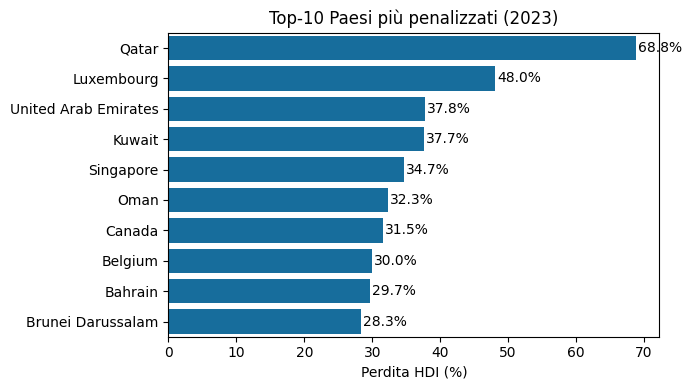

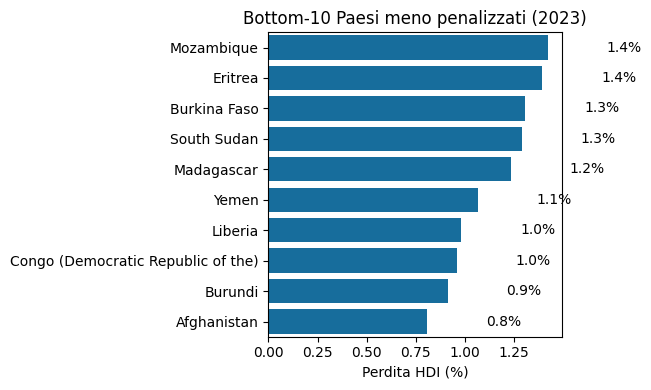

In [ ]:
# 5.2 Top-10 / Bottom-10
palette = sns.color_palette("colorblind")[0]   # blu accessibile

def add_labels(ax):
    """Stampa il valore numerico all'estremità di ogni barra."""
    for p in ax.patches:
        ax.text(p.get_width() + 0.3, p.get_y() + p.get_height()/2,
                f"{p.get_width():.1f}%", va='center')

# Top-10
top10 = snap23.nlargest(10, 'gap_pct')[['country', 'gap_pct']]
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=top10, x='gap_pct', y='country', ax=ax, color=palette)
ax.set_xlabel('Perdita HDI (%)')
ax.set_ylabel('')
ax.set_title('Top-10 Paesi più penalizzati (2023)')
add_labels(ax)
plt.tight_layout()
plt.show()

# Bottom-10
bottom10 = snap23.nsmallest(10, 'gap_pct')[['country', 'gap_pct']].sort_values('gap_pct', ascending=False)
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=bottom10, x='gap_pct', y='country', ax=ax, color=palette)
ax.set_xlabel('Perdita HDI (%)')
ax.set_ylabel('')
ax.set_title('Bottom-10 Paesi meno penalizzati (2023)')
add_labels(ax)
plt.tight_layout()
plt.show()


### 5.3 Correlazioni fra `gap_pct`, `co2_pc` e `mf_pc`

**Obiettivo**  
Capire quale delle due pressioni ambientali (CO₂ pro-capite o Material Footprint) è
maggiormente associata alla perdita percentuale di HDI.

| Passo | Azione | Indicazione che ci dà |
|-------|--------|-----------------------|
| 1 | Calcolo **Pearson** | Forza della relazione **lineare** fra le variabili. |
| 2 | Calcolo **Spearman** | Forza della relazione **monotona** (robusta a outlier o non-linearità). |
| 3 | Heatmap di Pearson | Confronto visivo immediato dei coefficienti (scala −1 … +1). |

> Se i due coefficienti sono simili in valore assoluto, la relazione è
> sia lineare sia monotona; se Spearman ≫ Pearson potremmo avere un trend
> curvilineo.


Correlazioni (Pearson):


,gap_pct,co2_pc,mf_pc
gap_pct,1.00,0.87,0.97
co2_pc,0.87,1.00,0.71
mf_pc,0.97,0.71,1.00


Correlazioni (Spearman):


,gap_pct,co2_pc,mf_pc
gap_pct,1.00,0.92,0.98
co2_pc,0.92,1.00,0.84
mf_pc,0.98,0.84,1.00


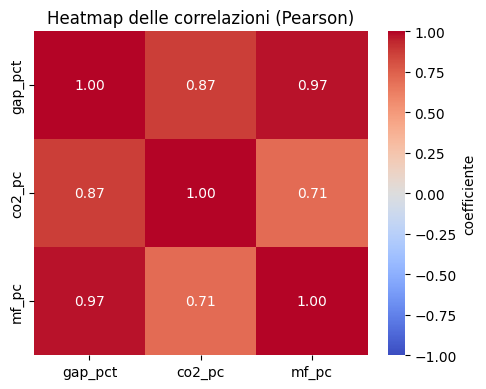

In [ ]:
# 5.3 Correlazioni
vars_to_corr = ['gap_pct', 'co2_pc', 'mf_pc']

# 1) Pearson & Spearman
pearson  = snap23[vars_to_corr].corr(method='pearson').round(2)
spearman = snap23[vars_to_corr].corr(method='spearman').round(2)

print("Correlazioni (Pearson):")
display(pearson)
print("Correlazioni (Spearman):")
display(spearman)

# 2) Heatmap di Pearson
plt.figure(figsize=(5,4))
sns.heatmap(
    pearson,
    annot=True, fmt=".2f",
    cmap='coolwarm', vmin=-1, vmax=1,
    cbar_kws={'label':'coefficiente'}
)
plt.title('Heatmap delle correlazioni (Pearson)')
plt.tight_layout()
plt.show()


#### Commento ai risultati delle correlazioni  

* **Material Footprint è il driver più forte** – la correlazione tra `gap_pct`
  e `mf_pc` è quasi perfetta ( *r* = 0,97 Pearson; ρ = 0,98 Spearman), segno che
  l’impronta materiale pro-capite spiega la quota maggiore della perdita di HDI.

* **CO₂ pro-capite conta, ma un po’ meno** – il legame con `gap_pct`
  resta molto alto ( *r* = 0,87; ρ = 0,92), però inferiore a quello del
  Material Footprint.  
  > *Interpretazione:* MF include consumi di risorse lungo tutta la filiera
  > e dunque cattura impatti più ampi delle sole emissioni di CO₂.

* **Pressioni tra loro correlate** – `co2_pc` e `mf_pc` condividono una
  correlazione positiva medio-alta ( *r* = 0,71; ρ = 0,84); prevedibile perché
  produzioni/materiali energivori generano CO₂.  
  Di conseguenza, in analisi multivariate occorrerà tenere conto di
  **multicollinearità**.

* **Spearman > Pearson** di qualche punto indica che la relazione resta
  monotona anche dove potrebbe non essere esattamente lineare
  (possibile “curva a gomito” per Paesi con footprint altissimo).


### 5.4 Confronto dei driver nei Top-10 Paesi

**Obiettivo**  
Capire se, nei Paesi più penalizzati, pesi di più l’impronta materiale o le
emissioni di CO₂ rispetto alla media mondiale.

| Passo | Azione | Lettura del risultato |
|-------|--------|-----------------------|
| 1 | Calcoliamo **z-score** di `co2_pc` e `mf_pc` sull’intero snapshot 2023 (µ = 0, σ = 1). | Valori **> 0** indicano livelli sopra la media globale; **< 0** sotto la media. |
| 2 | Selezioniamo i 10 Paesi con `gap_pct` più alto. | Questi rappresentano gli outlier negativi in termini di perdita di HDI. |
| 3 | Barplot orizzontale a barre affiancate (`z_co2` vs `z_mf`) ordinato per `gap_pct`. | Se in un Paese la barra verde (`z_mf`) supera nettamente la barra arancione (`z_co2`), il Material Footprint è il driver dominante, e vice-versa. |

> **Nota** – Usiamo gli z-score per rendere le due variabili comparabili pur avendo
> unità di misura diverse (t di CO₂ vs t di materiali).


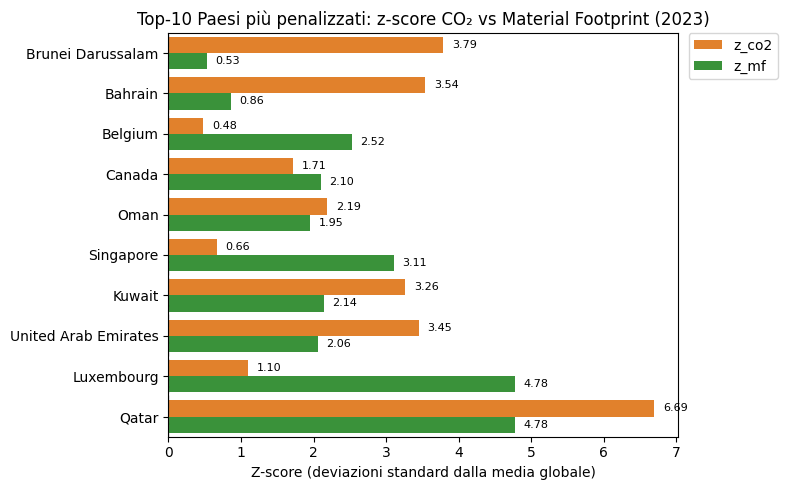

In [ ]:
# 5.4 Z-score CO₂ vs Material Footprint nei Top-10
# 1) Calcolo z-score globali
snap23['z_co2'] = (snap23['co2_pc'] - snap23['co2_pc'].mean()) / snap23['co2_pc'].std()
snap23['z_mf']  = (snap23['mf_pc']  - snap23['mf_pc'].mean())  / snap23['mf_pc'].std()

# 2) Top-10 per gap_pct (ordinati dal meno al più penalizzato per grafico orizzontale)
top10 = (snap23
         .nlargest(10, 'gap_pct')
         .sort_values('gap_pct', ascending=True))

# 3) Reshape long
plot_df = top10.melt(id_vars='country',
                     value_vars=['z_co2', 'z_mf'],
                     var_name='Indicatore',
                     value_name='z_score')

# 4) Barplot
plt.figure(figsize=(8,5))
palette = {'z_co2': '#FF7F0E', 'z_mf': '#2CA02C'}
ax = sns.barplot(data=plot_df,
                 x='z_score', y='country',
                 hue='Indicatore', palette=palette)

ax.axvline(0, color='grey', lw=1, ls='--')

# Etichette numeriche solo se |z| > 0.3
for p in ax.patches:
    width = p.get_width()
    if abs(width) < 0.3:
        continue
    x_txt = width + 0.12 if width > 0 else width - 0.12
    ha    = 'left' if width > 0 else 'right'
    ax.text(x_txt, p.get_y() + p.get_height()/2,
            f'{width:.2f}',
            va='center', ha=ha, fontsize=8)

ax.set_xlabel('Z-score (deviazioni standard dalla media globale)')
ax.set_ylabel('')
ax.set_title('Top-10 Paesi più penalizzati: z-score CO₂ vs Material Footprint (2023)')

# Legenda in alto a destra, fuori dal plot
ax.legend(title='', loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.tight_layout()
plt.show()


#### Lettura del grafico  

* **Paesi del Golfo (Qatar, EAU, Kuwait, Oman, Bahrain, Brunei)**  
  presentano z-score ben più alto sulla **CO₂ pro-capite**: qui la perdita di HDI
  è trainata soprattutto dalle emissioni legate a produzione ed esportazione di
  combustibili fossili.

* **Lussemburgo, Singapore, Canada, Belgio**  
  mostrano invece z-score superiore sul **Material Footprint**: la penalità di
  sviluppo deriva più dal consumo intensivo di risorse (importazioni di materie,
  filiere ad alto input materiale) che dalle sole emissioni di CO₂.

**Interpretazione operativa**

- Nei Paesi esportatori di energia il driver prioritario da mitigare è la CO₂:
  politiche di decarbonizzazione e diversificazione energetica possono ridurre
  direttamente la perdita di HDI.
- Nei Paesi ad alta intensità di consumo è più efficace intervenire
  sull’**efficienza nell’uso dei materiali** (economia circolare, tassazione su
  risorse primarie) per contenere l’impronta ecologica complessiva.


### 5.5 Identificazione degli outlier (metodo IQR)

**Obiettivo**  
Individuare i Paesi che, per una qualunque delle tre variabili chiave, si collocano
nelle code estreme della distribuzione.

| Passo | Azione |
|-------|--------|
| 1 | Calcoliamo Q1, Q3 e **IQR** (= Q3 − Q1) per `gap_pct`, `co2_pc`, `mf_pc`. |
| 2 | Definiamo come outlier i valori **< Q1 − 1.5·IQR** o **> Q3 + 1.5·IQR**. |
| 3 | Salviamo gli outlier in un dizionario `outliers` → per ciascuna variabile elenchiamo i Paesi “bassi” e “alti”. |
| 4 | Visualizziamo tre boxplot per un riscontro visivo immediato. |

> Il metodo IQR è robusto perché non assume distribuzione normale; basta la
> distanza interquartile per definire le code estreme.



► gap_pct:  outlier bassi = 0, alti = 6


,country,gap_pct
142,Qatar,68.848758
102,Luxembourg,48.047722
184,United Arab Emirates,37.765957
92,Kuwait,37.676056
157,Singapore,34.672304
131,Oman,32.284382



► co2_pc:  outlier bassi = 0, alti = 11


,country,co2_pc
142,Qatar,42.597623
24,Brunei Darussalam,26.008786
12,Bahrain,24.588744
184,United Arab Emirates,24.102838
92,Kuwait,23.023414
152,Saudi Arabia,19.925970
131,Oman,16.904567
8,Australia,14.485056
186,United States,14.445414
31,Canada,14.164020



► mf_pc:  outlier bassi = 0, alti = 5


,country,mf_pc
102,Luxembourg,74.1710
142,Qatar,74.1406
157,Singapore,53.0402
16,Belgium,45.6710
92,Kuwait,40.8308


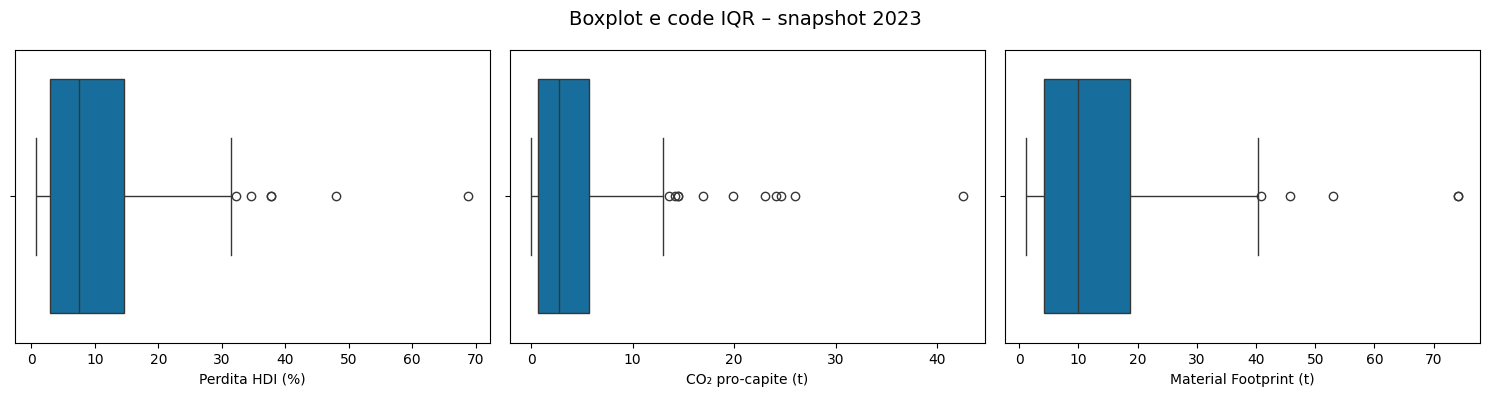

In [ ]:
# 5.5 Outlier detection con metodo IQR
vars_to_check = ['gap_pct', 'co2_pc', 'mf_pc']
outliers = {}

for var in vars_to_check:
    q1  = snap23[var].quantile(0.25)
    q3  = snap23[var].quantile(0.75)
    iqr = q3 - q1
    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    low_out  = snap23[snap23[var] <  lower_lim][['country', var]]
    high_out = snap23[snap23[var] >  upper_lim][['country', var]]

    outliers[var] = {'low': low_out, 'high': high_out}

    print(f"\n► {var}:  outlier bassi = {len(low_out)}, alti = {len(high_out)}")

    if not low_out.empty:
        display(low_out.sort_values(var))
    if not high_out.empty:
        display(high_out.sort_values(var, ascending=False))

# 4) Boxplot delle tre variabili
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, var, title in zip(
        axes,
        ['gap_pct', 'co2_pc', 'mf_pc'],
        ['Perdita HDI (%)', 'CO₂ pro-capite (t)', 'Material Footprint (t)']):
    sns.boxplot(x=snap23[var], ax=ax, color=sns.color_palette("colorblind")[0])
    ax.set_xlabel(title)

fig.suptitle('Boxplot e code IQR – snapshot 2023', fontsize=14)
plt.tight_layout()
plt.show()

#### Commento sugli outlier (metodo IQR)

| Variabile | # outlier alti | Paesi coinvolti | Lettura rapida |
|-----------|----------------|-----------------|----------------|
| `gap_pct` | **6** | Qatar, Luxembourg, UAE, Kuwait, Singapore, Oman | Perdono tra il 32 % e il 69 % dell’HDI: sono gli stessi Paesi già emersi nei grafici precedenti. |
| `co2_pc`  | **11** | (oltre ai 6 sopra) Brunei Darussalam, Saudi Arabia, Australia, USA, Canada, Mongolia | Outlier guidati da produzione di idrocarburi (Golfo), grandi economie energivore (USA, Australia, Canada) o carbone (Mongolia). |
| `mf_pc`   | **5** | Luxembourg, Qatar, Singapore, Belgium, Kuwait | Piccoli Stati ad alto reddito che importano molti beni/materiali rispetto alla popolazione. |

**Sintesi**

* **Qatar** è outlier su *tutte e tre* le metriche: caso limite di sviluppo umano fortemente “eroso” dalle pressioni ambientali.  
* I Paesi del Golfo dominano negli outlier di CO₂ e `gap_pct`, confermando che le emissioni legate al petrolio/gas sono il driver principale della loro penalità HDI.  
* Luxembourg e Singapore emergono soprattutto per **Material Footprint**, segno che il consumo di risorse (importate) pesa più delle emissioni domestiche.


## 6. Analisi per gruppi  

### 6.1 Analisi per regione  

**Obiettivo**  
Misurare come la perdita di HDI (`gap_pct`) e le due pressioni ambientali
(`co2_pc`, `mf_pc`) varino tra le principali macro-aree del mondo.

| Passo | Azione |
|-------|--------|
| 1 | Aggiungiamo a `snap23` la colonna `region` dal dataset originario (`df`). |
| 2 | Convertiamo i codici in etichette leggibili (`Arab States`, `Latin America & Caribbean`, …). |
| 3 | Calcoliamo *media*, *mediana* e *deviazione standard* di `gap_pct`, `co2_pc`, `mf_pc` per ciascuna macro-area. |
| 4 | Visualizziamo un barplot della **media di `gap_pct`** per regione, ordinato dal valore più alto al più basso. |

> Il confronto regionale aiuta a capire dove le pressioni ambientali penalizzano
> maggiormente lo sviluppo umano e dove, invece, l’impatto medio è contenuto.


gap_pct               co2_pc                mf_pc  \
                             mean median    std   mean median    std   mean   
region_full                                                                   
Arab States                 15.06   6.10  17.94   9.15   3.13  11.88  16.42   
East Asia & Pacific         13.02   8.75  10.46   6.26   3.39   7.11  16.15   
Europe & Central Asia        8.75   7.48   4.46   4.46   3.57   3.27  10.53   
Latin America & Caribbean    7.77   6.73   4.33   2.33   2.06   1.32  11.29   
South Asia                   5.32   3.53   4.65   2.09   0.88   2.95   7.17   
Sub-Saharan Africa           2.72   2.14   1.81   0.72   0.29   1.24   4.10   

                                         
                          median    std  
region_full                              
Arab States                 8.09  18.76  
East Asia & Pacific        11.73  13.40  
Europe & Central Asia       9.99   5.07  
Latin America & Caribbean   9.46   7.04  
South Asia                  4.78   7.33  
Sub-Saharan Africa          3.47   2.57

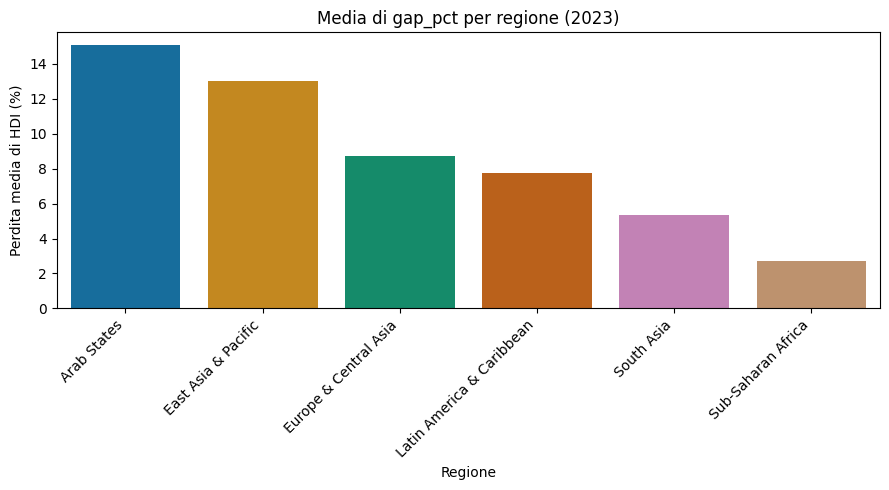

In [ ]:
# 6.1 Analisi per regione
# 1) Colonna 'region' → merge sicuro (se già c'è non duplica)
if 'region' not in snap23.columns:
    snap23 = snap23.merge(df[['country', 'region']], on='country', how='left')

# 2) Mappa codici → nomi estesi
region_map = {
    'AS':  'Arab States',
    'EAP': 'East Asia & Pacific',
    'ECA': 'Europe & Central Asia',
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'SSA': 'Sub-Saharan Africa'
}
snap23['region_full'] = snap23['region'].map(region_map)

# 3) Statistiche descrittive
region_stats = (snap23
                .groupby('region_full')[['gap_pct','co2_pc','mf_pc']]
                .agg(['mean','median','std'])
                .round(2))
display(region_stats)

# 4) Barplot della media gap_pct per regione (ordinato)
gap_mean = region_stats[('gap_pct', 'mean')].sort_values(ascending=False)
df_plot  = gap_mean.reset_index()
df_plot.columns = ['region_full', 'gap_mean']

# palette a 6 colori esatta
palette_6 = dict(zip(df_plot['region_full'],
                     sns.color_palette("colorblind", len(df_plot))))

plt.figure(figsize=(9,5))
sns.barplot(data=df_plot,
            x='region_full', y='gap_mean',
            hue='region_full', palette=palette_6,
            legend=False)          # niente legenda: le etichette sono già sull’asse X
plt.xticks(rotation=45, ha='right')
plt.xlabel('Regione')
plt.ylabel('Perdita media di HDI (%)')
plt.title('Media di gap_pct per regione (2023)')
plt.tight_layout()
plt.show()

### 6.2 Analisi per categoria di sviluppo umano  

**Obiettivo**  
Verificare se l’impatto delle pressioni ambientali sullo sviluppo umano
(`gap_pct`) varia al crescere del livello di HDI.

| Passo | Azione |
|-------|--------|
| 1 | Aggiungiamo la colonna `hdicode` (Low, Medium, High, Very High) a `snap23`. |
| 2 | Calcoliamo **media, mediana, deviazione standard e numerosità** di `gap_pct` in ciascuna categoria. |
| 3 | Disegniamo un **boxplot** di `gap_pct` ordinato dal gruppo Low a Very High. |

> Il confronto tra boxplot mostra sia la tendenza centrale sia la dispersione
> (code, outlier) per i diversi livelli di sviluppo umano.


,mean,median,std,count
hdicode,,,,
Low,2.04,1.91,1.25,25
Medium,3.92,2.82,2.75,32
High,7.49,6.44,4.05,37
Very High,19.36,16.30,10.77,62


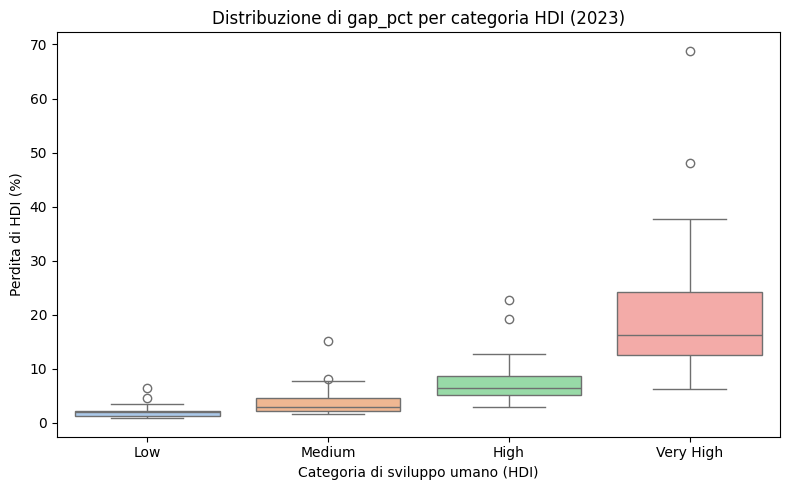

In [ ]:
# 6.2 Box-plot di gap_pct per categoria HDI
order_hdi = ['Low', 'Medium', 'High', 'Very High']

# 0) Se la colonna 'hdicode' non è presente, la uniamo ora
if 'hdicode' not in snap23.columns:
    snap23 = snap23.merge(
        df[['country', 'hdicode']],
        on='country', how='left'
    )

# 1) Statistiche riassuntive
hdi_stats = (snap23.groupby('hdicode')['gap_pct']
             .agg(['mean', 'median', 'std', 'count'])
             .reindex(order_hdi)
             .round(2))
display(hdi_stats)

# 2) Box-plot con palette a 4 colori (no warning)
plt.figure(figsize=(8,5))
palette_4 = dict(zip(order_hdi, sns.color_palette("pastel", 4)))

ax = sns.boxplot(
    data=snap23,
    x='hdicode', y='gap_pct',
    order=order_hdi,
    hue='hdicode',      # hue = stessa variabile, evita il FutureWarning
    palette=palette_4,
    dodge=False         # un solo box per categoria
)

ax.legend_.remove()     # nessuna legenda ridondante
ax.set_xlabel('Categoria di sviluppo umano (HDI)')
ax.set_ylabel('Perdita di HDI (%)')
ax.set_title('Distribuzione di gap_pct per categoria HDI (2023)')

plt.tight_layout()
plt.show()


## 7. Mappe geografiche  

### 7.1 Choropleth della perdita di HDI (`gap_pct`)

**Obiettivo**  
Visualizzare su scala mondiale quanto la perdita percentuale di HDI varia da
Paese a Paese.

| Passo | Dettaglio |
|-------|-----------|
| 1 | `locations='iso3'` → Plotly riconosce i confini usando il codice ISO-3. |
| 2 | `color='gap_pct'` con scala **RdYlGn_r** (verde = basso impatto, rosso = alto impatto). |
| 3 | `range_color` impostato al 95° percentile per evitare che pochi outlier “schiaccino” la scala cromatica. |

Il risultato è una mappa interattiva: spostando il mouse compaiono il nome del
Paese e il valore esatto di `gap_pct`.


In [ ]:
# 7.1 Choropleth di gap_pct (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='gap_pct',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['gap_pct'].quantile(0.95)),   # taglia i super-outlier
    title='Perdita percentuale di HDI (gap_pct) – anno 2023',
    labels={'gap_pct': 'Perdita HDI (%)'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='HDI&nbsp;loss&nbsp;%')
)

fig.show()


### 7.2 Choropleth delle emissioni di CO₂ pro-capite (`co2_pc`)

**Obiettivo**  
Mettere a fuoco i “mega-emettitori” e, in generale, la distribuzione geografica
delle emissioni di CO₂ per abitante nel 2023.

| Passo | Dettaglio |
|-------|-----------|
| 1 | `locations='iso3'` → identifica i confini nazionali tramite il codice ISO-3. |
| 2 | `color='co2_pc'` con scala **RdYlGn_r** (verde = basse emissioni, rosso = alte). |
| 3 | `range_color` limitato al 95° percentile per non appiattire la leggenda a causa di pochi outlier estremi. |

In [ ]:
# 7.2 Choropleth CO₂ pro-capite (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='co2_pc',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['co2_pc'].quantile(0.95)),   # taglia al 95° perc.
    title='Emissioni di CO₂ pro-capite (t) – anno 2023',
    labels={'co2_pc': 't CO₂ pro-capite'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='t&nbsp;CO₂<br>pro-capite')
)

fig.show()

### 7.3 Choropleth del Material Footprint pro-capite (`mf_pc`)

**Obiettivo**  
Mostrare dove il consumo di risorse (Material Footprint) è più intenso nel 2023.

| Passo | Dettaglio |
|-------|-----------|
| 1 | `locations='iso3'` per tracciare i confini nazionali. |
| 2 | `color='mf_pc'` con scala **RdYlGn_r** (verde = basso footprint, rosso = alto). |
| 3 | `range_color` tagliato al 95° percentile per evitare che pochi valori eccezionali comprimano la leg­enda cromatica. |


In [ ]:
# 7.3 Choropleth Material Footprint (2023)
fig = px.choropleth(
    snap23,
    locations='iso3',
    color='mf_pc',
    hover_name='country',
    color_continuous_scale='RdYlGn_r',
    range_color=(0, snap23['mf_pc'].quantile(0.95)),
    title='Material Footprint pro-capite (t) – anno 2023',
    labels={'mf_pc': 't di risorse pro-capite'}
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(title='t&nbsp;risorse<br>pro-capite')
)

fig.show()

## 8. Analisi temporale  

### 8.1 Paesi che migliorano o peggiorano di più  
Confrontiamo l’evoluzione di `gap_pct` dal 1990 al 2023:

1. **Costruiamo** un DataFrame “long” (`ts`) con `country × year × gap_pct`.  
2. **Calcoliamo** la variazione assoluta `Δ gap_pct = gap_pct 2023 – gap_pct 1990`.  
3. **Selezioniamo** i 10 paesi che hanno ridotto di più la perdita di HDI (*miglioramenti*) e i 10 che l’hanno aumentata di più (*peggioramenti*).  
4. **Visualizziamo** un bar-chart divergente; la linea verticale a 0 distingue i due gruppi.

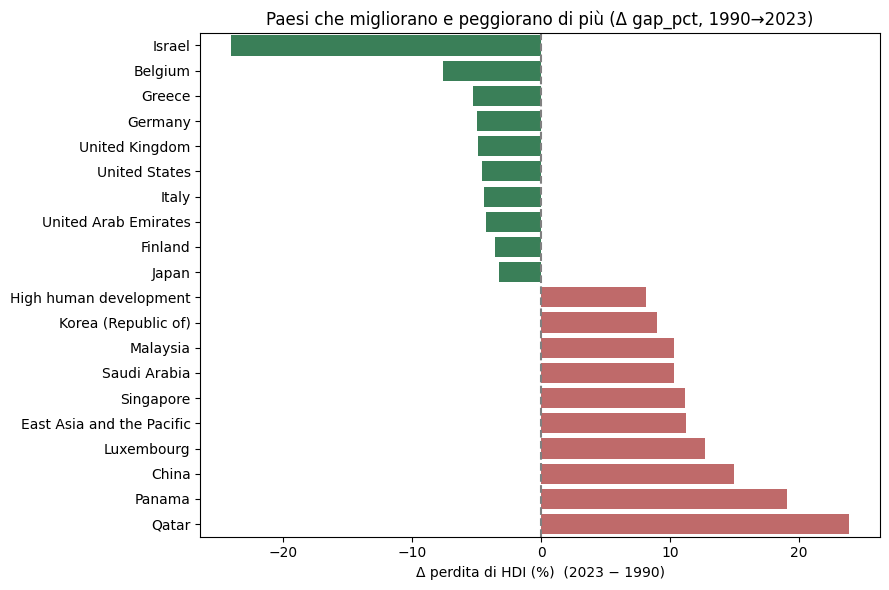

In [ ]:
# 8.1 Δ gap_pct 1990 → 2023
# 1) Costruzione del DataFrame long (country, year, gap_pct)
years = range(1990, 2024)
records = []

for y in years:
    hdi_col, phdi_col = f'hdi_{y}', f'phdi_{y}'
    if {hdi_col, phdi_col}.issubset(df.columns):
        tmp = df[['country', hdi_col, phdi_col]].dropna()
        tmp = tmp.rename(columns={hdi_col: 'hdi', phdi_col: 'phdi'})
        tmp['year']    = y
        tmp['gap_pct'] = (tmp['hdi'] - tmp['phdi']) / tmp['hdi'] * 100
        records.append(tmp[['country', 'year', 'gap_pct']])

ts = pd.concat(records, ignore_index=True)

# 2) Pivot: colonne 1990 e 2023 → calcolo Δ
delta_df = ts.pivot(index='country', columns='year', values='gap_pct').reset_index()
delta_df['delta_gap_pct'] = delta_df[2023] - delta_df[1990]

# 3) Top-10 miglioramenti / peggioramenti
top_improved = delta_df.nsmallest(10, 'delta_gap_pct')[['country', 'delta_gap_pct']]
top_worsened = delta_df.nlargest(10,  'delta_gap_pct')[['country', 'delta_gap_pct']]

top_improved['type'] = 'Miglioramento'
top_worsened['type'] = 'Peggioramento'

subset = (pd.concat([top_improved, top_worsened])
            .sort_values('delta_gap_pct'))

# 4) Bar-chart divergente (senza legenda)
plt.figure(figsize=(9,6))
sns.barplot(data=subset,
            x='delta_gap_pct', y='country',
            hue='type', dodge=False,
            palette={'Miglioramento':'seagreen', 'Peggioramento':'indianred'})

plt.axvline(0, color='grey', ls='--')
plt.xlabel('Δ perdita di HDI (%)  (2023 − 1990)')
plt.ylabel('')
plt.title('Paesi che migliorano e peggiorano di più (Δ gap_pct, 1990→2023)')

plt.legend([],[], frameon=False)  # rimuove la legenda
plt.tight_layout()
plt.show()


### 8.2 Trend di `gap_pct` (1990 – 2023) per macro-area  

**Obiettivo**  
Osservare come la perdita media di HDI è cambiata, anno dopo anno, nelle
principali regioni del mondo.

| Passo | Azione |
|-------|--------|
| 1 | Creiamo un DataFrame “long” (`ts`) con `country × year × gap_pct`. |
| 2 | Aggiungiamo `region_full` (Arab States, EAP, ECA, LAC, SA, SSA). |
| 3 | Calcoliamo la **media annuale** di `gap_pct` in ogni regione. |
| 4 | Disegniamo un line-plot multiplo: una curva per regione. |

> La media è costruita su tutti i Paesi che dispongono di dati HDI e PHDI per
> l’anno considerato; eventuali annate mancanti sono automaticamente escluse.


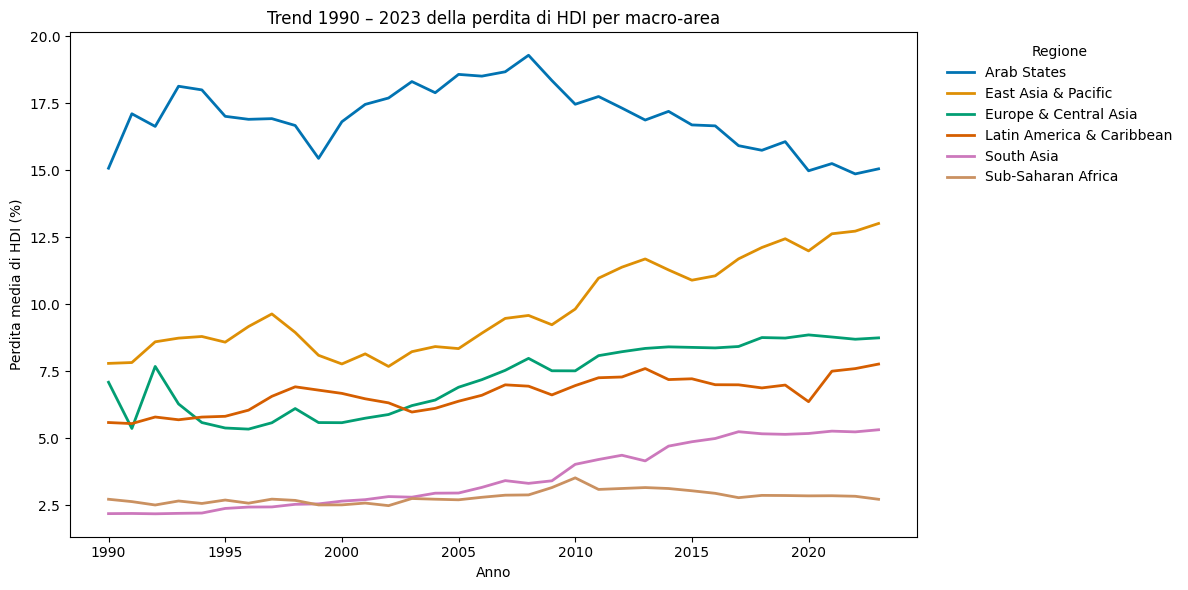

In [ ]:
# 8.2 Trend di gap_pct per macro-area
# 1) Costruzione del DataFrame long
years = range(1990, 2024)
records = []

for y in years:
    hdi_col, phdi_col = f'hdi_{y}', f'phdi_{y}'
    if {hdi_col, phdi_col}.issubset(df.columns):
        tmp = df[['country', 'region', hdi_col, phdi_col]].dropna()
        tmp = tmp.rename(columns={hdi_col: 'hdi', phdi_col: 'phdi'})
        tmp['year']    = y
        tmp['gap_pct'] = (tmp['hdi'] - tmp['phdi']) / tmp['hdi'] * 100
        records.append(tmp[['country', 'region', 'year', 'gap_pct']])

ts = pd.concat(records, ignore_index=True)

# 2) Mappatura dei codici regione
region_map = {
    'AS':  'Arab States',
    'EAP': 'East Asia & Pacific',
    'ECA': 'Europe & Central Asia',
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'SSA': 'Sub-Saharan Africa'
}
ts['region_full'] = ts['region'].map(region_map)

# 3) Media annuale per regione
trend = (ts.groupby(['region_full', 'year'])['gap_pct']
           .mean()
           .reset_index()
           .dropna(subset=['region_full']))  # esclude eventuali righe senza mappa

# 4) Multi-line plot
plt.figure(figsize=(12,6))
sns.lineplot(data=trend,
             x='year', y='gap_pct',
             hue='region_full',
             palette=sns.color_palette("colorblind", 6),
             lw=2)

plt.xlabel('Anno')
plt.ylabel('Perdita media di HDI (%)')
plt.title('Trend 1990 – 2023 della perdita di HDI per macro-area')

# Legenda all’esterno per non sovrapporsi al grafico
plt.legend(title='Regione', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

## 9. Segmentazione a quadranti (2023)

In questo grafico:

* **Dividiamo** i Paesi in quattro categorie usando due soglie fisse  
  – `thr_mf = 10 t` di Material Footprint pro-capite  
  – `thr_gap = 10 %` di perdita di HDI (`gap_pct`)  
* **Coloriamo** i punti con una palette accessibile (blu, verde, arancio, rosso).  
* **Evidenziamo** i quadranti con un leggero riempimento trasparente e inseriamo
  il nome di ciascuna area al centro.  
* **Contiamo** i Paesi per categoria e riportiamo i numeri nel titolo.  
* **Rendiamo** il grafico interattivo: al passaggio del mouse compaiono il nome
  del Paese, il footprint (t) e la perdita di HDI (%).

> **Interpretazione rapida**  
> *High-High* (rosso) = paesi con contemporaneamente alto consumo di risorse e
> alta perdita di HDI; *Low-Low* (blu) = paesi virtuosi su entrambi gli assi; gli
> altri due quadranti indicano criticità più selettive (solo consumo o solo
> perdita).


In [ ]:
# Quadrant chart con sfondo evidenziato

# 1) Dati e soglie
thr_mf  = 10     # t pro-capite di Material Footprint
thr_gap = 10     # % di perdita di HDI

# Ricalcolo/assicurazione colonna 'quad' nello snapshot
conds  = [(snap23.gap_pct > thr_gap) & (snap23.mf_pc > thr_mf),
          (snap23.gap_pct <= thr_gap) & (snap23.mf_pc > thr_mf),
          (snap23.gap_pct > thr_gap) & (snap23.mf_pc <= thr_mf)]
labels = ['High-High', 'Low gap – High MF', 'High gap – Low MF']
snap23['quad'] = np.select(conds, labels, default='Low-Low')

quad_counts = snap23['quad'].value_counts().to_dict()

palette = {'High-High':'#D62728', 'Low gap – High MF':'#FFBB78',
           'High gap – Low MF':'#2CA02C', 'Low-Low':'#1F77B4'}

# 2) Scatter
fig = px.scatter(
    snap23, x='mf_pc', y='gap_pct',
    color='quad', hover_name='country',
    color_discrete_map=palette,
    labels={'mf_pc':'Material Footprint (t)',
            'gap_pct':'HDI loss %'},
    title=(f"Quadrant chart: MF vs HDI loss (2023)  |  "
           f"HH={quad_counts.get('High-High',0)}  "
           f"LH={quad_counts.get('Low gap – High MF',0)}  "
           f"HL={quad_counts.get('High gap – Low MF',0)}  "
           f"LL={quad_counts.get('Low-Low',0)}")
)

# 3) Linee soglia
fig.add_vline(x=thr_mf, line_width=2, line_dash='dot', line_color='black')
fig.add_hline(y=thr_gap, line_width=2, line_dash='dot', line_color='black')

# 4) Evidenzia quadranti con fill trasparente
xmin, xmax = snap23.mf_pc.min(), snap23.mf_pc.max()
ymin, ymax = snap23.gap_pct.min(), snap23.gap_pct.max()

quadrant_specs = [
    # (x0, y0, x1, y1, color, name)
    (thr_mf, thr_gap, xmax,  ymax,  'rgba(214, 39, 40, 0.05)', 'High-High'),
    (thr_mf, ymin,    xmax,  thr_gap, 'rgba(255, 187, 120, 0.05)', 'Low gap – High MF'),
    (xmin,   thr_gap, thr_mf, ymax,  'rgba(44, 160, 44, 0.05)',  'High gap – Low MF'),
    (xmin,   ymin,    thr_mf, thr_gap, 'rgba(31, 119, 180, 0.05)','Low-Low')
]

for x0, y0, x1, y1, color, _ in quadrant_specs:
    fig.add_shape(type='rect', x0=x0, y0=y0, x1=x1, y1=y1,
                  fillcolor=color, line=dict(width=0))

# 5) Etichette automatiche al centro di ogni rettangolo
for x0, y0, x1, y1, _, name in quadrant_specs:
    fig.add_annotation(x=(x0+x1)/2, y=(y0+y1)/2,
                       text=name, showarrow=False,
                       font=dict(size=11, color='grey'))

# 6) Hover sintetico + layout pulito
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>MF=%{x:.1f} t<br>HDI loss=%{y:.1f}%'
)

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgrey'),
    yaxis=dict(showgrid=True, gridcolor='lightgrey'),
    legend=dict(title='', orientation='v',
                yanchor='top', y=0.98, xanchor='left', x=1.02)
)

fig.show()


## 10. Conclusioni & Raccomandazioni

> **Domanda guida**  
> *Quanto e dove le pressioni ambientali (CO₂ pro-capite e Material Footprint) erodono lo sviluppo umano?*

### 10.1 Punti chiave

| # | Evidenza | Cosa significa |
|---|----------|----------------|
| **1** | **Perdita media globale 2023 ≈ 10 %** di HDI | Un decimo dei progressi di benessere è annullato dall’impatto ambientale. |
| **2** | **Material Footprint è il driver più forte** (ρ≈0,98, *r*≈0,97) | Il consumo di risorse pesa più delle sole emissioni sulla perdita di HDI. |
| **3** | **Cluster critico High-High** → 67 Paesi | Alto footprint *e* alta perdita di HDI: priorità d’intervento. |
| **4** | **Arab States & EAP** mostrano i trend peggiori 1990-2023 | Industrializzazione (EAP) e produzione fossile (Arab States) frenano lo sviluppo netto. |
| **5** | **Best performer**: Israele, Belgio, Germania (Δ gap ≤ -5 pp) | Efficienza energetica e politiche circolari riducono la penalità ambientale. |
| **6** | **Worst performer**: Qatar, Panama, Cina (Δ gap ≥ +15 pp) | Crescita trainata da risorse/energia con alto impatto ambientale. |

### 10.2 Raccomandazioni operative

1. **Ridurre il Material Footprint nei Paesi ad alto reddito**  
   *Strumenti* → tassazione su risorse vergini, incentivi a materiali riciclati, target di dematerializzazione settoriale.

2. **Accelerare la decarbonizzazione nei Paesi esportatori di energia**  
   *Strumenti* → eliminazione sussidi ai fossili, standard di efficienza per edifici e mobilità, investimento in rinnovabili e CCS.

3. **Adottare piani regionali su misura**  
   *Arab States* → focus CO₂;  
   *Europa* → consolidare i progressi su efficienza materiale;  
   *Asia Pacifico* → frenare l’aumento del gap con tecnologie low-carbon e circolari.

4. **Monitorare annualmente il quadrante High-High**  
   Pubblicare una lista di Paesi “sorvegliati speciali” e collegare l’accesso a fondi green a progressi misurabili su footprint/emissioni.

